In [1]:
import gym
import numpy as np
import torch
from torch.nn import Module, Linear
import matplotlib.pyplot as plt

In [1]:
### Author: Tammali Tharun(IITM, department of chemical engineering)

# CART POLE Problem

In [ ]:
▶ Actions: 1) Move left 2) Move right
▶ Rewards: 1 for every step until termination
▶ Termination States:
■ Pole angle is more than ±12 degrees
■ Cart position is more than ±2.4 units from centre
■ Episode length is more than 200
▶ Problem is deemed solved when the average reward is greater than or equal to 195 over 100 consecutive episodes

In [31]:
def exp_moving_avg(arr, beta=0.9):
    n = arr.shape[0]
    mov_avg = np.zeros(n)
    mov_avg[0] = (1-beta) * arr[0]
    for i in range(1, n):
        mov_avg[i] = beta * mov_avg[i-1] + (1-beta) * arr[i]
    return mov_avg


# Neural Network Based Policy

In [37]:
class policy(Module):
    def __init__(self, state_dim, n_actions, n_hidden):
        super(policy, self).__init__()
        self.state_dim = state_dim
        self.n_actions = n_actions
        self.fc1 = Linear(state_dim, n_hidden)
        self.fc2 = Linear(n_hidden, n_actions)
    
    def forward(self, X):
        X = self.fc1(X)
        X = torch.nn.LeakyReLU()(X)
        X = self.fc2(X)
        X = torch.nn.Softmax(dim=0)(X)
        return X
    
    def select_action(self, curr_state):
        # print("state = ",curr_state) 
        act_prob = self.forward(torch.Tensor(curr_state))
        selected_act = np.random.choice(self.n_actions, p=act_prob.data.numpy())
        return selected_act

In [38]:
def loss_function(prob, r):
    return -1*torch.sum(r*torch.log(prob))

In [45]:
state_dim = 4
n_actions = 2
n_hidden = 150
n_episodes = 700
max_episode_len = 300
lr = 0.01
discount = 0.9

history_episode_len  = np.zeros(n_episodes)
agent = policy(state_dim, n_actions, n_hidden)   
optimizer = torch.optim.Adam(agent.parameters(), lr=lr)
rewards = []

for episode in range(n_episodes):
    env = gym.make('CartPole-v1')
    state = env.reset()[0]
    transitions = []
    ep_reward = []
    for t in range(max_episode_len):
        action = agent.select_action(state)
        next_state, reward, terminated, truncated, info = env.step(action)
        ep_reward.append(reward)
        transitions.append((state, action, t+1))
        finished = terminated or truncated
        if finished:
            break
        
        state = next_state
        
    episode_len = len(transitions)
    history_episode_len[episode] = episode_len
    state_batch = torch.Tensor(np.array([s for (s,a,r) in transitions]))
    action_batch = torch.Tensor([a for (s,a,r) in transitions])
    reward_batch = torch.Tensor([r for (s,a,r) in transitions]).flip(dims=(0,))
    pred_batch = agent(state_batch)
    prob_batch = pred_batch.gather(dim=1,index=action_batch.long().view(-1,1)).squeeze()

    disc_return = torch.pow(discount, torch.arange(episode_len).float()) * reward_batch
    disc_return /= disc_return.max()

    loss = loss_function(prob_batch, disc_return)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()        
    env.close()

# Plot the Learning Curves

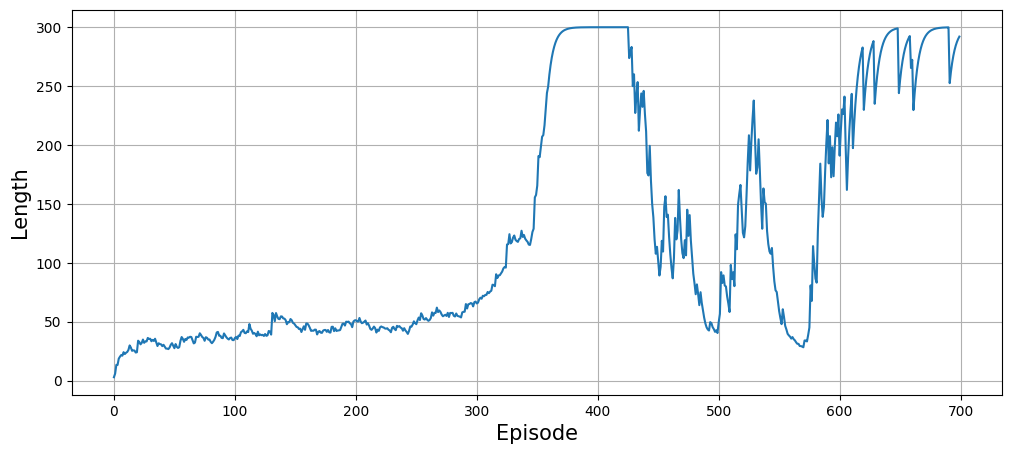

In [46]:
plt.figure(figsize=(12,5))
plt.plot(exp_moving_avg(history_episode_len, 0.8))
plt.xlabel("Episode", fontsize=15)
plt.ylabel("Length", fontsize=15)
plt.grid(True)

#### **Considering the below condition**
- Problem is deemed solved when the average reward is greater than or equal to **195 over 100 consecutive episodes**

In [42]:
def is_solved(rewards, threshold, window):
    if len(rewards) < window:
        return False, None  
    average_reward = np.mean(rewards[-window:])
    return average_reward >= threshold, average_reward

In [47]:
is_solved(history_episode_len,195,100)

(True, 273.61)

#### **After training the agent on the Cart-Pole problem:**
- I have monitored its performance by tracking the rewards obtained in each episode.
- I have applied the following criterion for considering the problem to be solved
- Which requires achieving an average reward of at least **195 over the last 100 consecutive episodes.**
- Upon analysis, I observed that the agent consistently obtained an average reward exceeding this threshold(195) over the specified 100-episode window and i conclude that the **Cart-Pole problem is effectively solved**.